In [343]:
%pip install simpletransformers -qU
%pip install wandb -qU

In [344]:
# Log in to your W&B account
import wandb
wandb.login()

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


True

In [345]:
# wandb.init(project="assigment")

In [346]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from nltk.corpus import stopwords
import transformers

In [347]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
from sklearn.preprocessing  import LabelEncoder
le = LabelEncoder()
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
import missingno as miss
from collections import Counter
import matplotlib.pyplot as plt
import plotly.express as px
from plotly.offline import iplot
import cufflinks as cf
cf.go_offline()

In [348]:
# df = pd.read_csv(io.BytesIO(uploaded['all-data.csv']))
# df = pd.read_csv(uploaded)
df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/all-data.csv", encoding='latin-1')
df.columns = ["Sentiment", "News Headline"]
df.describe(include = "all")

,Sentiment,News Headline
count,4846,4846
unique,3,4838
top,neutral,TELECOMWORLDWIRE-7 April 2006-TJ Group Plc sel...
freq,2879,2


In [349]:
df = df.drop_duplicates()


In [350]:
df['nr_of_char'] = df['News Headline'].str.len()
df['nr_of_char'] = df['nr_of_char'] / df['nr_of_char'].max()
df[['Sentiment', 'nr_of_char']].pivot(columns = 'Sentiment', values = 'nr_of_char').iplot(kind = 'box')

In [351]:
import re
import spacy
# nlp = spacy.load('en')
nlp = spacy.load("en_core_web_sm")

def normalize(msg):
  
    msg = re.sub('[^A-Za-z]+', ' ', msg) #remove special character and intergers
    doc = nlp(msg)
    res=[]
    for token in doc:
        if(token.is_stop or token.is_punct or token.is_currency or token.is_space or len(token.text) <= 2): #word filteration
            pass
        else:
            res.append(token.text)
    return res

  
# df["News Headline"] = df["News Headline"].apply(normalize)

In [352]:
rename = {"News Headline": "text", "Sentiment": "labels"}
df.rename(columns = rename, inplace=True)
# X_bert

In [353]:
# df["text"] = df["text"].apply(lambda x : " ".join(x))
df = df[["text", "labels"]]
df["labels"] = le.fit_transform(df["labels"])
df.head()

,text,labels
0,"According to Gran , the company has no plans t...",1
1,Technopolis plans to develop in stages an area...,1
2,The international electronic industry company ...,0
3,With the new production plant the company woul...,2
4,According to the company 's updated strategy f...,2


In [354]:
# # distil-bert tokenizer
# tokenizer_bert = transformers.DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
# X_bert = [tokenizer_bert(text, padding='max_length', max_length = 256, truncation=True)['input_ids'] for text in df['text']]
# X_bert = np.array(X_bert, dtype='int32')
# X_bert

In [355]:
train_x_y = df.sample(frac = 0.75, random_state = 42)
test_x_y = pd.concat([df, train_x_y]).drop_duplicates(keep=False)
test_x_y = df.drop(train_x_y.index)
train_x_y, test_x_y, test = np.split(df.sample(frac=1, random_state=42), [int(.6*len(df)), int(.8*len(df))])


# train_texts, val_texts, train_labels, val_labels = train_test_split(train_x_y["text"].tolist(), train_x_y["labels"].tolist(), test_size=.2)

# tokenizer = transformers.DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')

# train_encodings = tokenizer(train_texts, truncation=True, padding=True)
# val_encodings = tokenizer(val_texts, truncation=True, padding=True)
# test_encodings = tokenizer(test_x_y["text"].tolist(), truncation=True, padding=True)

# import tensorflow as tf

# train_dataset = tf.data.Dataset.from_tensor_slices((
#     dict(train_encodings),
#     train_labels
# ))

# val_dataset = tf.data.Dataset.from_tensor_slices((
#     dict(val_encodings),
#     val_labels
# ))

# test_dataset = tf.data.Dataset.from_tensor_slices((
#     dict(test_encodings),
#     test_x_y["labels"].tolist()
# ))


In [356]:
%pip install simpletransformers -qU

In [357]:
from simpletransformers.classification import ClassificationModel, ClassificationArgs

model_args = ClassificationArgs()
model_args.train_batch_size = 2
model_args.gradient_accumulation_steps = 8
model_args.learning_rate = 3e-5
model_args.num_train_epochs = 3
model_args.logging_dir='./logs'
model_args.logging_steps=2
model_args.overwrite_output_dir=True
model_args.wandb_project="assigment"

model_bert = ClassificationModel("bert", "bert-base-cased", num_labels=3, args=model_args, use_cuda=True)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at b

In [358]:
model_bert.train_model(train_x_y)

  0%|          | 0/2904 [00:00<?, ?it/s]

Epoch:   0%|          | 0/3 [00:00<?, ?it/s]

Running Epoch 0 of 3:   0%|          | 0/1452 [00:00<?, ?it/s]

Running Epoch 1 of 3:   0%|          | 0/1452 [00:00<?, ?it/s]

Running Epoch 2 of 3:   0%|          | 0/1452 [00:00<?, ?it/s]

(543, 0.45335791958410215)

In [359]:
# import torch
# torch.save(model_bert, 'trained')
x = model_bert.eval_model(test_x_y)

  0%|          | 0/968 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/121 [00:00<?, ?it/s]

Training loss,▄▄▅▂▄▂▂▃▂▃▃▃▃▁▂▅▁▁▂▂▅▂▁▃▁▆▁▁▁▁▁▁▁▂▁▁▁█▄▁
global_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
lr,▃▄████▇▇▇▇▇▇▆▆▆▆▅▅▅▅▅▅▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▁▁▁
Training loss,0.45068
global_step,542
lr,0.0


In [360]:
pred_bert, out_bert = model_bert.predict(list(test['text'].values))

acc_bert = accuracy_score(test['labels'].to_numpy(), pred_bert)
f1_bert = f1_score(test['labels'].to_numpy(), pred_bert, average='micro')

print("Accuracy Score -",acc_bert)
print("F1 Score - ", f1_bert)

  0%|          | 0/968 [00:00<?, ?it/s]

  0%|          | 0/121 [00:00<?, ?it/s]

Accuracy Score - 0.8336776859504132
F1 Score -  0.8336776859504134


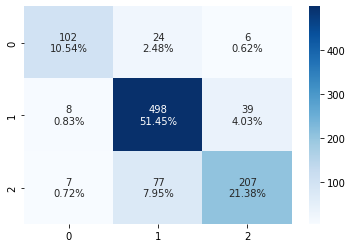

In [361]:
cm = confusion_matrix(pred_bert, test['labels'].to_numpy())

group_counts = ["{0:0.0f}".format(value) for value in cm.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in cm.flatten()/np.sum(cm)]
labels = [f"{v1}\n{v2}" for v1, v2 in zip(group_counts,group_percentages)]
labels = np.asarray(labels).reshape(3,3)
sns.heatmap(cm, annot=labels, fmt="", cmap='Blues')
plt.show()

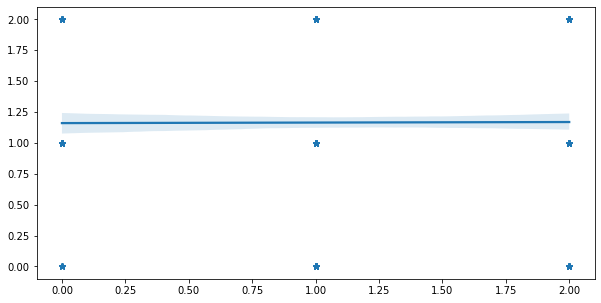

In [362]:
fig,ax=plt.subplots(figsize=(10,5))
sns.regplot(x=pred_bert, y=test_x_y['labels'].to_numpy(),marker="*")
plt.show()

In [364]:
import torch
torch.save(model_bert, 'final_model')

# saved_model = torch.load('path/to/model')